# Este notebook trata con el problema de clasificación de sobrevivenvia o no sobrevivencia de pasajeros del Titanic, un problema desafío clásico de Kaggle.
# Se dispone de un conjunto de entrenamiento y otro de testeo cuyos resultados posee Kaggle. Se realizan las etapas de análisis exploratorio, preprocesamiento y modelado.  El método de clasificación usado es Gradient Boosting Machine.
# Este notebook obtuvo un  score de 0.78468 en Kaggle ( top 32%). Es un mejoramiento con respecto al anterior donde se usa Decision Trees. 
 

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Abriendo archivos de entrenamiento y testeo

In [38]:
data_train=pd.read_csv('C:/Users/MAURICIO/Desktop/train.csv')
data_test=pd.read_csv('C:/Users/MAURICIO/Desktop/test.csv')

In [39]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Número de registros y columnas en train y test:**

In [41]:
data_train.shape, data_test.shape

((891, 12), (418, 11))

La columna Survived en data_test evidentemente no está, pues hay que predecirla.

In [42]:
data_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Visualización datos

###  Gráfico embarcados/sobrevivientes según sexo.

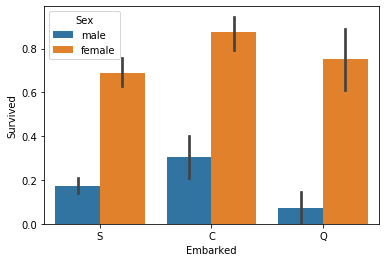

In [43]:
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=data_train)

Claramente, el sexo del pasajero es una variable predictiva importante en la sobrevivencia. En los tres tipos de embarques
sobreviven mucho más mujeres que hombres. Por otro lado, el embarque C es en donde sobreviven tanto más hombres que mujeres.

### Gráfico clase (1°, 2°, 3°) v/s sobrevivientes según sexo

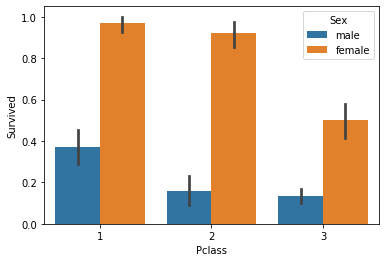

In [44]:
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=data_train)

El sexo de los pasajeros sigue siendo importante con respecto a la clase(1,2 o 3).Se ve también que el número 
de sobrevivientes en cada sexo va disminuyendo con la clase.Se ve mejor en un gráfico de puntos:

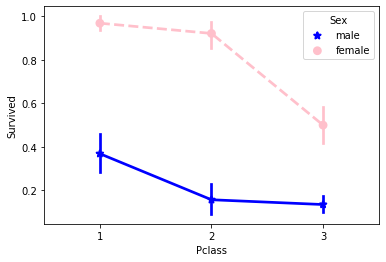

In [45]:
sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=data_train, 
              palette={'male':'blue','female':'pink'},markers=['*','o'],linestyles=['-','--'])

Luego,aparte del sexo, la clase es evidentemente una buena variable predictiva de sobrevivencia.

### Gráfico edad v/s sobrevivientes

Primero formamos  cuatro bins  con la variable edad: niños, jóvenes, adultos,tercera edad.

In [46]:
bins=np.linspace(min(data_train['Age']),max(data_train['Age']),5)
group_names=['niños','jovenes','adultos','tercera edad']
data_train['Age_bins']=pd.cut(data_train['Age'],bins,labels=group_names,include_lowest=True)

In [47]:
bins


array([ 0.42 , 20.315, 40.21 , 60.105, 80.   ])

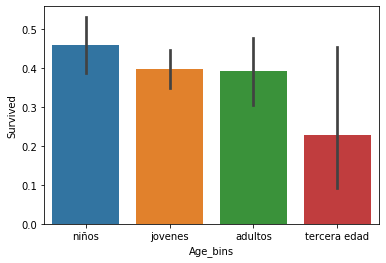

In [48]:
sns.barplot(x=data_train['Age_bins'],y=data_train['Survived'],data=data_train)

Podemos ver que a mayor edad, menor es la sobrevivencia. La edad es otra de nuestras variables predictivas.

#### Eliminación de Variables

Notemos por otro lado, que las variables Embarked y Pclass están relacionadas. Cada clase de pasajeros embarca por su propia
puerta. Así que sólo consideraremos la variable Pclass. Además, eliminaremos las variables que consideramos no útiles para efectos de predecir sobrevivencia: Ticket,Name,Cabin,PassengerId:


In [49]:
data_train.drop(['Ticket','Name','PassengerId','Cabin','Age_bins','Embarked'],axis=1,inplace=True)
data_test.drop(['Ticket','Name','Cabin','Embarked'],axis=1,inplace=True)

In [50]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


### Valores faltantes (Missing Data)

Veamos si hay valores indefinidos (NaN) en data_train y data_test:

In [51]:
data_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [52]:
data_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
dtype: int64

Hay 177 valores faltantes en data_train en la variable edad y 86 en data_test.
Veamos el porcentaje 

In [53]:
177/data_train.shape[0]*100, 86/data_test.shape[0]*100

(19.865319865319865, 20.574162679425836)

Así que hay aproximadamente un 20% de valores faltantes en la columna Age tanto en data_tetst como en data_train. No nos arriegaremos a eliminarlos y los sustituiremos por el promedio de la columna.

In [54]:
data_train = data_train.fillna(data_train.mean())
data_test=data_test.fillna(data_test.mean())

In [55]:
data_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

In [56]:
data_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

### Outliers

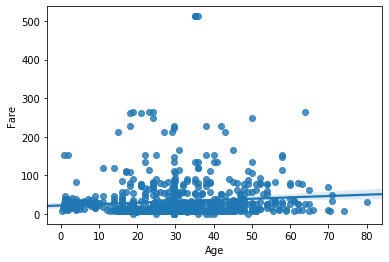

In [57]:
sns.regplot(x='Age',y='Fare',data=data_train)

In [58]:
condition=data_train['Age']>70
data_train[condition]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
96,0,1,male,71.0,0,0,34.6542
116,0,3,male,70.5,0,0,7.7500
493,0,1,male,71.0,0,0,49.5042
630,1,1,male,80.0,0,0,30.0000
851,0,3,male,74.0,0,0,7.7750


In [59]:
#data_train.drop([630],axis=0,inplace=True)  para borrar por ejemplo la fila con id 630

Claramente hay outliers. Son los valores de Fare mayores que 500. 

In [60]:
condition=data_train['Fare']>500
data_train[condition]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
258,1,1,female,35.0,0,0,512.3292
679,1,1,male,36.0,0,1,512.3292
737,1,1,male,35.0,0,0,512.3292


En vez de eliminar estos valores, los sustituiremos por un valor más cercano al resto. No conviene eliminar los registros, pues
corresponden a personas que sobrevivieron y como el conjunto de datos está desequilibrado hacia los no sobrevivientes, esto 
introduciría más sesgo aún.

In [61]:
data_train['Fare'].replace(512.3292,
                           270,inplace=True)

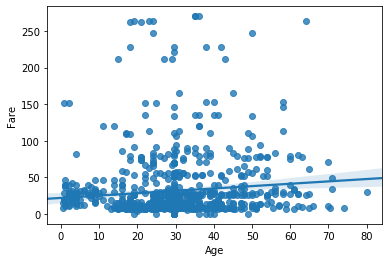

In [62]:
sns.regplot(x='Age',y='Fare',data=data_train)

### Variables categóricas a numéricas

Convertimos la variable Sex a numérica en data_test y data_train:

In [63]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le_train1=le.fit(data_train['Sex'])
le_test1=le.fit(data_test['Sex'])
data_train['Sex']=le_train1.transform(data_train['Sex'])
data_test['Sex']=le_test1.transform(data_test['Sex'])





In [64]:
data_train.head(5)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


### Normalización

No es necesario normalizar en este método

In [65]:
#X1=data_train[['Age','Fare']]
#X2=data_test[['Age','Fare']]
#data_train[['Age','Fare']]=preprocessing.StandardScaler().fit(X1).transform(X1.astype(float))
#data_test[['Age','Fare']]=preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))

### Division en training y test de data_train

Ahora dividimos el dataframe data_train en dos, uno de entrenamiento y otro para testear el modelo predictivo:

In [66]:
from sklearn.model_selection import train_test_split
d=data_train.drop(['Survived'],axis=1)
s=data_train['Survived']
d_train,d_test,s_train,s_test=train_test_split(d,s,test_size=0.2,random_state=19)

In [67]:
d_train.shape,s_train.shape,d_test.shape,s_test.shape

((712, 6), (712,), (179, 6), (179,))

## Modelación

In [68]:
gbrt=GradientBoostingClassifier(random_state=11,n_estimators=81,max_depth=3,learning_rate=0.095)
gbrt.fit(d_train,s_train)
YTT=gbrt.predict(d_train)
Predtree=gbrt.predict(d_test)

### Evaluación Modelo

#### Evaluación con datos entrenamiento

In [69]:
print(confusion_matrix(s_train,YTT))
print(classification_report(s_train,YTT))
print(accuracy_score(s_train, YTT))

[[411  26]
 [ 57 218]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       437
           1       0.89      0.79      0.84       275

    accuracy                           0.88       712
   macro avg       0.89      0.87      0.87       712
weighted avg       0.88      0.88      0.88       712

0.8834269662921348


#### Evaluación con datos test

In [70]:
print('Matriz de Confusión:','\n',confusion_matrix(s_test,Predtree))
print('Reporte de Clasificación:','\n',classification_report(s_test,Predtree))
print('\n')
print('Score:',accuracy_score(s_test, Predtree)*100,'%')

Matriz de Confusión: 
 [[108   4]
 [ 12  55]]
Reporte de Clasificación: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       112
           1       0.93      0.82      0.87        67

    accuracy                           0.91       179
   macro avg       0.92      0.89      0.90       179
weighted avg       0.91      0.91      0.91       179



Score: 91.06145251396647 %


## Importancia Variables

In [71]:
labels=[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for feature in zip(labels, gbrt.feature_importances_):
    print(feature)

('Pclass', 0.18543357428010931)
('Sex', 0.4720783154069622)
('Age', 0.1318679684191656)
('SibSp', 0.03829224084150736)
('Parch', 0.003552090220938304)
('Fare', 0.16877581083131715)


Las variables más importantes son Sex y Pclass, seguidas por Fare.La variable Sex resultó ser menos predictiva de lo que esperábamos. La menos importante es Parch.

**Una vez evaluado el modelo, volvemos a generarlo, esta vez usando todo el archivo data_train,para poder utilizarlo otra vez:**

In [72]:
X=data_train.drop(['Survived'],axis=1)
Y=data_train['Survived']
gbrt.fit(X,Y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.095, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=81,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=11, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Predicción Final

Finalmente, hacemos nuestra predicción con data_test:

In [73]:
ids=data_test['PassengerId']
Ysurvived=gbrt.predict(data_test.drop(['PassengerId'],axis=1))


In [74]:
output=pd.DataFrame({'PassengerId':ids,'Survived':Ysurvived})
output.to_csv('TitanicPred.csv',index=False)